<a href="https://colab.research.google.com/github/c820306/Alpha_camp_recommentation/blob/main/week3_1_cf_used_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample Code

## 基礎建設

In [ ]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [ ]:
# !wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
# !wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

In [ ]:
# metadata = getDF('/content/meta_All_Beauty.json.gz')
# ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [ ]:
metadata = getDF('./meta_All_Beauty.json.gz')
ratings = pd.read_csv('./All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [ ]:
metadata.head(3)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]


In [ ]:
ratings.head(3)

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800


## 資料整理

In [ ]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

## 資料切分

### 發現有客戶曾多次買同個商品

* 發現ratings有同一個客戶有同天同產品評價分數相同的狀況： 共9,070筆

In [ ]:
print(f"repeated rating of product:  {ratings.shape[0]- ratings.drop_duplicates().shape[0]}")


repeated rating of product:  9070


* 排除重複評價資料

In [ ]:
ratings = ratings.drop_duplicates()

In [ ]:
df = ratings.groupby(['reviewerID','asin'],as_index=False).agg(count=('reviewerID','count'))
repeated_purchase_product_users = df[ df['count']> 1]['reviewerID'].unique()
repeated_purchase_product = df[df['count']>1]['asin'].unique()

* 共603位客戶曾購買同一個商品(not on same day), 被重複購買商品數有153個
* 重複評價分數會影響後續user_to_item、item_to_user，採用最近的商品評價，共670筆排除

In [ ]:
print(f"the number of user for repeated purchase the same product: {len(repeated_purchase_product_users)}")
print(f"the number of product for being repeated purchased: {len(repeated_purchase_product)}")

the number of user for repeated purchase the same product: 603
the number of product for being repeated purchased: 153


In [ ]:
df = ratings[ratings['reviewerID'].isin(repeated_purchase_product_users)&
                  ratings['asin'].isin(repeated_purchase_product)
                 ].sort_values(['reviewerID','asin','DATE'], ascending=[True,True,False])
df

,asin,reviewerID,overall,unixReviewTime,DATE
12244,B00011QUDE,A108DY5IC7OVWT,3.0,1473552000,2016-09-11
12245,B00011QUDE,A108DY5IC7OVWT,1.0,1473552000,2016-09-11
74633,B001E5PLCM,A10CKOFTMAV45W,3.0,1356393600,2012-12-25
74634,B001E5PLCM,A10CKOFTMAV45W,4.0,1355270400,2012-12-12
90436,B002OITLG0,A10DOJIAIUIAEB,5.0,1519948800,2018-03-02
...,...,...,...,...,...
226967,B01AAVIO38,AZBLP8S3CHH3,4.0,1460160000,2016-04-09
193603,B00W259T7G,AZBOC8H7QQGJC,3.0,1436313600,2015-07-08
193749,B00W259T7G,AZBOC8H7QQGJC,4.0,1422489600,2015-01-29
194060,B00W259T7G,AZWIAYHWL2FWE,4.0,1395100800,2014-03-18


In [ ]:
keep = df.drop_duplicates(subset=['asin','reviewerID'],keep='first').index
repeated_drop_set = set(df.index) - set(keep)
keep_list = list(set(ratings.index) - repeated_drop_set)

print(f"the number of repeated purchase not recently--> delete: {len(repeated_drop_set)}")

the number of repeated purchase not recently--> delete: 670


In [ ]:
ratings = ratings.loc[keep_list]
ratings.shape

(361605, 5)

In [ ]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

In [ ]:
print(ratings_trainings.shape)
print(ratings_testings.shape)

(361012, 5)
(590, 5)


## EDA

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

### 整體客戶之評分分布

- 75.8% rating分數 >= 4，客戶的商品評分都給蠻高的

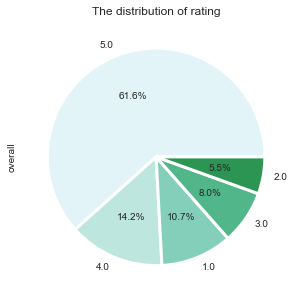

In [ ]:
colors = sns.color_palette("BuGn")[:5]
fig, ax = plt.subplots(figsize=(5, 5))
ax = ratings['overall'].value_counts().plot.pie(autopct='%.1f%%',
       wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
       colors = colors )
ax.set_title("The distribution of rating")
plt.show()

In [ ]:
ratings['overall'].value_counts().to_frame()

,overall
5.0,222891
4.0,51411
1.0,38539
3.0,28875
2.0,19889


### 客戶評分分布 vs 時間

* 綜觀時間維度，其分佈與整體差異不大，4分以上為主要佔比(70~80%)

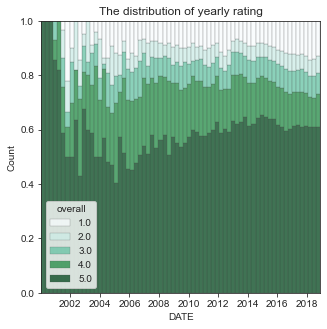

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.histplot(
    data = ratings,
    x="DATE", hue="overall",
    multiple="fill",
    palette="BuGn",
    edgecolor=".3",
    linewidth=.2,
    binwidth = (100)
)
ax.set_title('The distribution of yearly rating')
plt.show()

### 每個客戶之購買次數分佈

* 客戶主要購買次數為1次（佔90.9%)

In [ ]:
ratings['reviewerID'].value_counts().to_frame()

,reviewerID
A2GJX2KCUSR0EI,24
A1KSC91G9AIY2Z,22
AENH50GW3OKDA,20
A22CW0ZHY3NJH8,18
A1UQBFCERIP7VJ,16
...,...
A3VF3RO1P1VA71,1
A3OVQO2WWU4VS7,1
A1SOTHUZHXEBJV,1
A1ICKAWVLDNURL,1


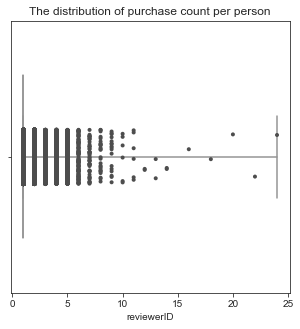

In [ ]:
def range_tag(x):
    if x == 1:
        return '1 time'
    elif x == 2:
        return '2 times'
    elif x > 2 and x <=5 :
        return '3~5 times'
    else:
        return 'more than 5 times' 
    
fig, ax = plt.subplots(figsize=(5, 5))
reviewerID_count = ratings['reviewerID'].value_counts().to_frame()

ax = sns.boxplot(x='reviewerID', data=reviewerID_count,
            whis=[0, 100], width=.6, palette="vlag"
                )
sns.stripplot(x= 'reviewerID', data=reviewerID_count,
              size=4, color=".3", linewidth=0)

ax.set_title('The distribution of purchase count per person')
plt.show()

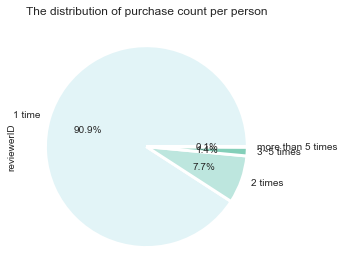

In [ ]:
colors = sns.color_palette("BuGn")[:5]
reviewerID_count_df = reviewerID_count['reviewerID'].apply(range_tag).value_counts()
ax = reviewerID_count_df.plot.pie(autopct='%.1f%%',
       wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, colors=colors)
ax.set_title('The distribution of purchase count per person', fontsize=12)
plt.tight_layout()

### 每位客戶購買次數分佈 vs 時間

* 從2008年後開始明顯有客戶購買3次以上，但2016年開始客戶購買之次數開始有走下坡趨勢

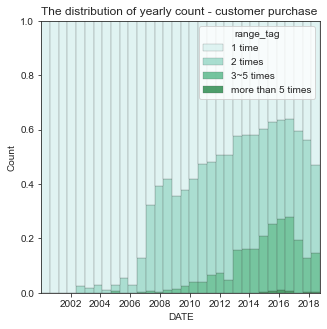

In [ ]:
df = ratings.groupby(['DATE','reviewerID'], as_index=False).agg(count =('reviewerID','count'))
df['range_tag'] = df['count'].apply(range_tag)
df = df.groupby(['DATE','range_tag'], as_index=False).agg(count =('range_tag','count'))

fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.histplot(
    data = df,
    x="DATE", hue="range_tag",
    multiple="fill",
    palette="BuGn",
    edgecolor=".3",
    linewidth=.2,
)

ax.set_title('The distribution of yearly count - customer purchase ')
plt.show()

### 整體商品之購買次數分佈

* 每個商品總購買次數區間主要落在1～2000之間

In [ ]:
asin_count = ratings['asin'].value_counts().to_frame().reset_index()
asin_count[:10]

,index,asin
0,B000FOI48G,8656
1,B000GLRREU,8341
2,1620213982,4791
3,B001QY8QXM,4505
4,B01DKQAXC0,4240
5,B006IB5T4W,2789
6,B00W259T7G,2603
7,B00005JS5C,2249
8,B00VF344X0,1964
9,B0067F28ZW,1850


<AxesSubplot:xlabel='asin'>

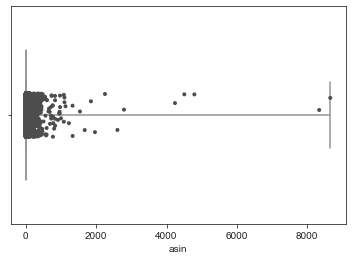

In [ ]:
ax = sns.boxplot(x='asin', data=asin_count,
            whis=[0, 100], width=.6, palette="vlag"
                )
sns.stripplot(x='asin', data=asin_count,
              size=4, color=".3", linewidth=0)


In [ ]:
def range_tag(x):
    if x > 0 and x <=10:
        return '1~10'
    elif x > 10 and x <=50 :
        return '11~50'
    elif x > 50 and x <=100 :
        return '50~100'
    elif x > 100 and x <=300 :
        return '100~300'
    elif x > 300 and x <=1000 :
        return '300~1000'
    elif x > 1000 and x <=4000 :
        return '1000~4000'
    else:
        return 'more than 4000' 

asin_count['range_tag']= asin_count['asin'].apply(range_tag)
asin_count['range_tag'].value_counts()

1~10              28038
11~50              3435
50~100              571
100~300             411
300~1000            111
1000~4000            15
more than 4000        5
Name: range_tag, dtype: int64

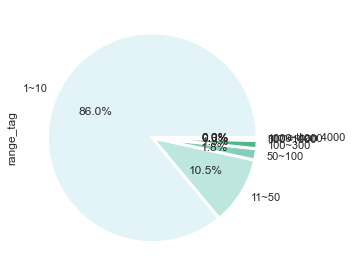

In [ ]:
colors = sns.color_palette("BuGn")[:5]
asin_count['range_tag'].value_counts().plot.pie(autopct='%.1f%%',
       wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, colors=colors)
ax.set_title('The distribution of purchase count per person', fontsize=12)
plt.tight_layout()

### 商品的購買次數分佈 vs 時間

* 每月商品購買次數主要1~2次（約佔80%)

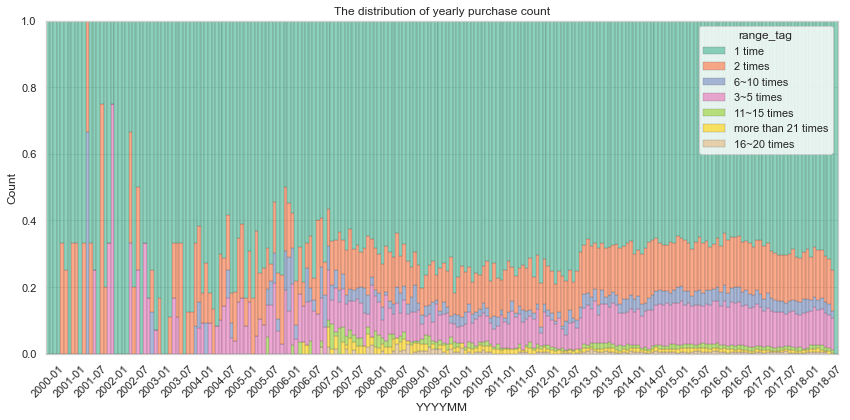

In [ ]:
from datetime import datetime 
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker

def range_tag(x):
    if x == 1:
        return '1 time'
    elif x == 2:
        return '2 times'
    elif x > 2 and x <=5 :
        return '3~5 times'
    elif x > 5 and x <=10 :
        return '6~10 times'
    elif x > 10 and x <=15 :
        return '11~15 times'
    elif x > 15 and x <=20 :
        return '16~20 times'
    else:
        return 'more than 21 times' 

ratings['YYYYMM'] = ratings['DATE'].dt.strftime('%Y-%m')
df = ratings.groupby(['YYYYMM','asin'], as_index=False).agg(count =('asin','count'))
df['range_tag'] = df['count'].apply(range_tag)
df['range_tag'] = df['count'].apply(lambda x : range_tag(x))

tickspacing=3
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.histplot(
    data = df,
    x="YYYYMM", hue="range_tag",
    multiple="fill",
    palette="Set2",
    edgecolor=".3",
    linewidth=.2,
    binwidth = (500)
)

ax.set_title('The distribution of yearly purchase count')
ax.xaxis.set_major_locator(MultipleLocator(6))
ax.tick_params(axis='x', labelrotation=45 )
plt.tight_layout()
plt.show()

### 評價與銷量關係

* 商品平均評價越高，不一定與商品銷量有正向或負向關係，因此決定評價不納入相似度篩選條件

In [ ]:
df = ratings.groupby(['asin'],as_index=False).agg(sale_count=('asin','count'), avg_overall=('overall','mean'))
df = df[df['sale_count']<=1000]

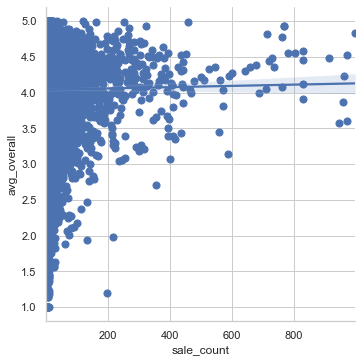

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(x="sale_count", y="avg_overall", data=df,
           scatter_kws={"s": 50, "alpha": 1})


## 產生推薦

In [ ]:
import pandas as pd
from itertools import combinations
from collections import defaultdict

# header: user_id,item_id,rating,timestamp

def recommender(training_data, users=[], k=10):

    # loading data from dataframe
    # user_to_items dict:
    # {
    #   'user': {
    #       'item': ratings...
    #   }...
    # }
    user_to_items = defaultdict(dict)
    for _, row in training_data.iterrows():
        
        row = dict(row)
        user = row['reviewerID']
        item = row['asin']
        rating = float(row['overall'])

        user_to_items[user][item] = rating

    print("total users before filtering: ", len(user_to_items))

    # remove obscure user to decrease data size
    # filtering params
    remove_obscure_user = True
    user_rating_threshold = 3   
    all_users = list(user_to_items.keys())
    for user in all_users:
        ratings = user_to_items[user]
        if remove_obscure_user and len(ratings) < user_rating_threshold:
            del user_to_items[user]

    print("total users  after filtering: ", len(user_to_items))

    # generate item to user mapping dict
    # {
    #   'item': {
    #       'user': ratings...
    #   }...
    # }
    item_to_users = defaultdict(dict)
    for user, items in user_to_items.items():
        for item, rating in items.items():
            item_to_users[item][user] = rating
    
    print("total items : ", len(item_to_users))

    # prepare data of computing user similarity
    # generate pre_user_similarity dict
    # {
    #   'user1': {
    #       'user2': [xy, xx, yy ],
    #.      'user3': [xy, xx, yy ]...
    #   }...
    # }
    init_sim = lambda: [0 for _ in range(3)]
    factory = lambda: defaultdict(init_sim)
    pre_user_similarity = defaultdict(factory)
    n = len(item_to_users)
    index = 0
    for item, user_ratings in item_to_users.items():
        if len(user_ratings) > 1:
            # print(f"item: {item} have been rated by {len(user_ratings)} users progress: {index}/{n}")
            for user1, user2 in combinations(user_ratings.keys(), 2):
                xy = user_ratings[user1] * user_ratings[user2]
                xx = user_ratings[user1] ** 2
                yy = user_ratings[user2] ** 2
                pre_user_similarity[user1][user2][0] += xy
                pre_user_similarity[user1][user2][1] += xx
                pre_user_similarity[user1][user2][2] += yy

                pre_user_similarity[user2][user1][0] += xy
                pre_user_similarity[user2][user1][1] += xx
                pre_user_similarity[user2][user1][2] += yy
        index += 1

    user_similarity = {}
    for src_user in pre_user_similarity:
        user_similarity_order = []
        for dst_user, val in pre_user_similarity[src_user].items():
            xy = val[0]
            xx = val[1]
            yy = val[2]
            div = ((xx*yy) ** 0.5)
            if div == 0:
                continue
            similarity = xy / div
            if similarity < 0:
                continue
            for i, s in enumerate(user_similarity_order):
                target_similarity = s[1]
                if target_similarity < similarity:
                    user_similarity_order.insert(i, (dst_user, similarity))
                    break
            else: # 有當迴圈裡沒有遇到 break 時，else 塊才會執行，當最後一個similarlity比target_similarity會執行
                user_similarity_order.append((dst_user, similarity))
        user_similarity[src_user] = user_similarity_order

    recommendation = {}
    for user in users:  # testing data user
        if user in user_similarity: #if testing in user_similarity
            sim_users = user_similarity[user] #[(dst_user, similarity),(dst_user, similarity)...]
            recommended_items = []
            recommended_items_set = set() 
            user_have_rated = set(user_to_items[user])  #{item1, item2, ...} 避免key重複，用戶評的商品清單
            stop_recommend = False
            for sim_user, _ in sim_users: #[(dst_user, similarity),(dst_user, similarity)...]
                items_from_sim_user = sorted(list(user_to_items[sim_user].items()), key=lambda item: item[1]) #user_to_items針對用戶商品的評分，由小排到大，[(item1:1),(item2:2)...]
                for item, rating in items_from_sim_user: #item, _ --> item, rating
                    if item not in user_have_rated and item not in recommended_items_set:
                        recommended_items.append(item)
                        recommended_items_set.add(item)
                    if len(recommended_items) >= k: #recommended_items_set why not?
                        stop_recommend = True
                        break
                if stop_recommend:
                    break
            recommendation[user] = recommended_items
        else:
            recommendation[user] = []
    return recommendation

ratings_by_user = recommender(ratings_trainings, users)

total users before filtering:  323489
total users  after filtering:  4793
total items :  4853


## 結果評估

In [ ]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))
            if len(set(ratings_by_user[d])) > 0:
                if len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))> 0:
                    print(f'user: {d} , Match!!!')
                    print("recommendation: ",  ratings_by_user[d])
                    print("real buy: ",  ratings_testings_by_user[d] )
                    print()
                else: 
                    print(f'user: {d} , Not match!!!')
                    print("recommendation: ",  ratings_by_user[d])
                    print("real buy: ",  ratings_testings_by_user[d] )
                    print()

    score = total / len(ratings_testings)
    return score

score = evaluate(ratings_testings_by_user, ratings_by_user)

print(f"The evaluation result is {score}")

user: A1SA3N793WT2LM , Not match!!!
recommendation:  ['B0007QKY80', 'B0001TMDF0', 'B0021YV3C2', 'B01BZV6VVY', 'B015ZVFK1W', 'B019Z9JUC0', 'B019Z9L8PW', 'B00NPJVLYW', 'B00CR6X0IY', 'B00L5E74VS']
real buy:  ['B01GAFCQOQ']

user: ACE1ZIOI3U6PY , Not match!!!
recommendation:  ['B00PMRE5A2', 'B00QHX7NT0', 'B01E7UKR38', 'B005IZD7BG', 'B000067E30', 'B006WZ9ZHQ']
real buy:  ['B01GOSELHE']

user: ASGIVOW34XNQS , Not match!!!
recommendation:  ['1620213982', 'B000KNELAW', 'B01DJI7796', 'B00006IGL2', 'B0001WXTPA', 'B0002JHI1I', 'B00120VWTK', 'B01DEDYWD0', 'B00021DJ32', 'B003I5SDJO']
real buy:  ['B01CGPN2D8']

The evaluation result is 0.0


In [ ]:
print(f'{len([user for user in ratings_by_user if len(ratings_by_user[user])>0 ])} users have recommendations')

3 users have recommendations


### 為何user-based表現不佳

In [ ]:
users_38_df = ratings_trainings[ratings_trainings['reviewerID'].isin(ratings_testings['reviewerID'])]
users_38_user = users_38_df['reviewerID'].unique()

In [ ]:
print(f"First, among {len(ratings_by_user)} testing users, there are only {len(users_38_user)} user have purchase records between 2000 and 2018.")

First, among 584 testing users, there are only 38 user have purchase records between 2000 and 2018.


In [ ]:
users_38_df = users_38_df.groupby(['reviewerID']).agg(list).reset_index()[['reviewerID','asin']]
users_38_df['count'] = users_38_df['asin'].apply(lambda x : len(x))

In [ ]:
users_38_df

,reviewerID,asin,count
0,A13JU88JAHN72I,[B009YDVB6Q],1
1,A16Y7V1CZCWKFV,[B015ZOWER2],1
2,A19503XX7GU6J2,"[B019Z9LD98, B019Z9LAPK]",2
3,A1EY751AUVO5NZ,[B01ENDFXJW],1
4,A1PR178735XC70,[B00NNLURMY],1
5,A1SA3N793WT2LM,"[B0054H0NZ6, B007EITOSK, B0075OYLKY, B012TQ6AXS]",4
6,A1TP9JHTIY468V,"[B01E6NITSG, B01CTKQL56]",2
7,A1UAOE8KO7Q1DZ,[B006NXZ7TC],1
8,A1WEFBEJ7OHSVZ,[B002OITLG0],1
9,A1WSZED2O5MA5T,[B000WYJTZG],1


In [ ]:
print(f"Secondly, {len(users_38_user)} users have purchased, however 92.1% users purchased less than 3 times")

Secondly, 38 users have purchased, however 92.1% users purchased less than 3 times


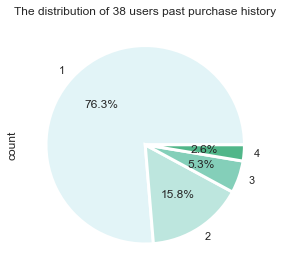

In [ ]:
colors = sns.color_palette("BuGn")[:5]
ax = users_38_df['count'].value_counts().plot(kind='pie',autopct='%.1f%%',
       wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, colors=colors)
ax.set_title('The distribution of 38 users past purchase history', fontsize=12)
plt.tight_layout()

In [ ]:
print(f"Therefore, only {len(users_38_df[users_38_df['count']>2]['reviewerID'])} users have recommendations, but score is {score}, which doesn't perform well.")


Therefore, only 3 users have recommendations, but score is 0.0, which doesn't perform well.


## Conclusion

* User-based推薦準度為0%
* 多數使用者購買次數主要落在3次以下，導致過濾排除購買次數小於3項的使用者時，多數使用者會被排除掉，同時也導致有成功被推薦的使用者，其產品推薦難達到10個商品推薦數，造成使用user-based無法有較佳成效
